In [1]:
#!pip install -e git+https://github.com/casperbroch/ai-economist@stockmarket#egg=ai-economist

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
# Define the configuration of the environment that will be built

env_config_dict = {
    # ===== SCENARIO CLASS =====
    # Which Scenario class to use: the class's name in the Scenario Registry (foundation.scenarios).
    # The environment object will be an instance of the Scenario class.
    'scenario_name': 'stock_market_simulation',
    
    # ===== COMPONENTS =====
    # Which components to use (specified as list of ("component_name", {component_kwargs}) tuples).
    #   "component_name" refers to the Component class's name in the Component Registry (foundation.components)
    #   {component_kwargs} is a dictionary of kwargs passed to the Component class
    # The order in which components reset, step, and generate obs follows their listed order below.
    'components': [
        # (1) Building houses
        ('BuyOrSellStocks', {}),
        # (2) Trading collectible resources
        ('ExecCircuitBreaker', {}),
    ],
    

    # ===== STANDARD ARGUMENTS ======
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment)
    'n_agents': 4,          # Number of non-planner agents (must be > 1)
    'world_size': [1, 1], # [Height, Width] of the env world
    'episode_length': 100, # Number of timesteps per episode
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': False,
    
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    'flatten_observations': False,
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    'flatten_masks': True,
    'dense_log_frequency': 1
}

In [4]:
from rllib.env_wrapper import RLlibEnvWrapper
env_obj = RLlibEnvWrapper({"env_config_dict": env_config_dict}, verbose=True)

Inside covid19_components.py: 0 GPUs are available.
No GPUs found! Running the simulation on a CPU.
Inside covid19_env.py: 0 GPUs are available.
No GPUs found! Running the simulation on a CPU.


C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\caspe\AppData\Roaming\Python\Python37\site-

[EnvWrapper] Spaces
[EnvWrapper] Obs (a)   
BuyOrSellStocks-stock_price: (1,)
action_mask    : (21,)
time           : (1,)
world-Endogenous-AbleToBuy: (1,)
world-Endogenous-AbleToSell: (1,)
world-Endogenous-AvailableFunds: (1,)
world-Endogenous-Demand: (1,)
world-Endogenous-Labor: (1,)
world-Endogenous-NumberOfStocks: (1,)
world-Endogenous-StockPrice: (1,)
world-Endogenous-StockPriceHistory: (100,)
world-Endogenous-StocksLeft: (1,)
world-Endogenous-Supply: (1,)
world-Endogenous-TotalBalance: (1,)
world-Endogenous-Volumes: (100,)


[EnvWrapper] Obs (p)   
action_mask    : (2,)
time           : (1,)
world-Prices_History: (100,)
world-Total_Demand: (1,)
world-Total_Supply: (1,)
world-Volumes  : (100,)


[EnvWrapper] Action (a) Discrete(21)
[EnvWrapper] Action (p) Discrete(2)


In [5]:
import ray
from ray.rllib.agents.ppo import PPOTrainer

In [6]:
policies = {
    "a": (
        None,  # uses default policy
        env_obj.observation_space,
        env_obj.action_space,
        {}  # define a custom agent policy configuration.
    ),
    "p": (
        None,  # uses default policy
        env_obj.observation_space_pl,
        env_obj.action_space_pl,
        {}  # define a custom planner policy configuration.
    )
}

# In foundation, all the agents have integer ids and the social planner has an id of "p"
policy_mapping_fun = lambda i: "a" if str(i).isdigit() else "p"

policies_to_train = ["a", "p"]

In [7]:
trainer_config = {
    "multiagent": {
        "policies": policies,
        "policies_to_train": policies_to_train,
        "policy_mapping_fn": policy_mapping_fun,
    }
}

In [8]:
trainer_config.update(
    {
        "num_workers": 2,
        "num_envs_per_worker": 2,
        # Other training parameters
        "train_batch_size":  4000,
        "sgd_minibatch_size": 4000,
        "num_sgd_iter": 1
    }
)

In [9]:
# We also add the "num_envs_per_worker" parameter for the env. wrapper to index the environments.
env_config = {
    "env_config_dict": env_config_dict,
    "num_envs_per_worker": trainer_config.get('num_envs_per_worker'),   
}

trainer_config.update(
    {
        "env_config": env_config        
    }
)

In [10]:
# Initialize Ray
ray.init(webui_host="127.0.0.1")

2024-05-03 11:07:55,505	INFO resource_spec.py:212 -- Starting Ray with 4.05 GiB memory available for workers and up to 2.04 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2024-05-03 11:07:57,012	INFO services.py:1165 -- View the Ray dashboard at 127.0.0.1:8265


{'node_ip_address': '192.168.1.41',
 'raylet_ip_address': '192.168.1.41',
 'redis_address': '192.168.1.41:6379',
 'object_store_address': 'tcp://127.0.0.1:59260',
 'raylet_socket_name': 'tcp://127.0.0.1:53032',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\caspe\\AppData\\Local\\Temp\\ray\\session_2024-05-03_11-07-55_495661_6836'}

In [11]:
# Create the PPO trainer.
trainer = PPOTrainer(
    env=RLlibEnvWrapper,
    config=trainer_config,
    )

2024-05-03 11:08:02,397	ERROR syncer.py:46 -- Log sync requires rsync to be installed.
2024-05-03 11:08:02,402	INFO trainer.py:585 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2024-05-03 11:08:02,404	INFO trainer.py:612 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(pid=3544) C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=3544)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=3544) C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=3544)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=3544) C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=3544)   _np_qint16 = np.dtype([("qint16", n

(pid=17228) Inside covid19_components.py: 0 GPUs are available.
(pid=17228) No GPUs found! Running the simulation on a CPU.
(pid=3544) Inside covid19_components.py: 0 GPUs are available.
(pid=3544) No GPUs found! Running the simulation on a CPU.
(pid=17228) Inside covid19_env.py: 0 GPUs are available.
(pid=17228) No GPUs found! Running the simulation on a CPU.
(pid=3544) Inside covid19_env.py: 0 GPUs are available.
(pid=3544) No GPUs found! Running the simulation on a CPU.


2024-05-03 11:08:22,902	INFO trainable.py:181 -- _setup took 20.503 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


In [12]:
NUM_ITERS = 10
start_train = time.time()

for iteration in range(NUM_ITERS):
    print(f'********** Iter : {iteration} **********')
    start = time.time()
    result = trainer.train()
    length = time.time() - start
    print(f'''episode_reward_mean: {result.get('episode_reward_mean')}''')
    print(f'''it_time_taken: {length}''')

    
length_train = time.time() - start_train
print("Training took", length_train, " seconds.")

********** Iter : 0 **********
episode_reward_mean: -3.1179059743019994
it_time_taken: 22.687315225601196
********** Iter : 1 **********
episode_reward_mean: -2.9506578594916957
it_time_taken: 14.665164709091187
********** Iter : 2 **********
episode_reward_mean: -2.9887028373066107
it_time_taken: 13.520360231399536
********** Iter : 3 **********
episode_reward_mean: -2.686216198820011
it_time_taken: 13.560426950454712
********** Iter : 4 **********
episode_reward_mean: -2.750779989899131
it_time_taken: 13.742302894592285
********** Iter : 5 **********
episode_reward_mean: -2.723318922195986
it_time_taken: 13.813912868499756
********** Iter : 6 **********
episode_reward_mean: -2.7493309347586488
it_time_taken: 13.86541748046875
********** Iter : 7 **********
episode_reward_mean: -2.8099882471852657
it_time_taken: 13.709246635437012
********** Iter : 8 **********
episode_reward_mean: -2.9460035696986506
it_time_taken: 13.349444389343262
********** Iter : 9 **********
episode_reward_mean

In [13]:
#env_obj.env.get_agent(3).state

In [14]:
def generate_rollout_from_current_trainer_policy(
    trainer, 
    env_obj,
    num_dense_logs=1
):
    dense_logs = {}
    for idx in range(num_dense_logs):
        # Set initial states
        agent_states = {}
        for agent_idx in range(env_obj.env.n_agents):
            agent_states[str(agent_idx)] = trainer.get_policy("a").get_initial_state()
        planner_states = trainer.get_policy("p").get_initial_state()   

        # Play out the episode
        obs = env_obj.reset(force_dense_logging=True)
        for t in range(env_obj.env.episode_length):
            actions = {}
            for agent_idx in range(env_obj.env.n_agents):
                # Use the trainer object directly to sample actions for each agent
                actions[str(agent_idx)] = trainer.compute_action(
                    obs[str(agent_idx)], 
                    agent_states[str(agent_idx)], 
                    policy_id="a",
                    full_fetch=False
                )

            # Action sampling for the planner
            actions["p"] = trainer.compute_action(
                obs['p'], 
                planner_states, 
                policy_id='p',
                full_fetch=False
            )

            obs, rew, done, info = env_obj.step(actions)        
            if done['__all__']:
                break
        dense_logs[idx] = env_obj.env.dense_log
    return dense_logs

In [15]:
dense_logs = generate_rollout_from_current_trainer_policy(
    trainer, 
    env_obj,
    num_dense_logs=5
)

In [16]:
#dense_logs[0]['states'][0]

In [17]:
#planner_gr_score_importances = [log["p"]["GreenScoreImportance"] for log in dense_logs[0]['states']]

In [18]:
agent_0_green_scores = [log["0"]["endogenous"]["TotalBalance"] for log in dense_logs[0]['states']]
agent_1_green_scores = [log["1"]["endogenous"]["TotalBalance"] for log in dense_logs[0]['states']]
agent_2_green_scores = [log["2"]["endogenous"]["TotalBalance"] for log in dense_logs[0]['states']]
agent_3_green_scores = [log["3"]["endogenous"]["TotalBalance"] for log in dense_logs[0]['states']]

stock_prices = [log["0"]["endogenous"]["StockPrice"] for log in dense_logs[0]['states']]

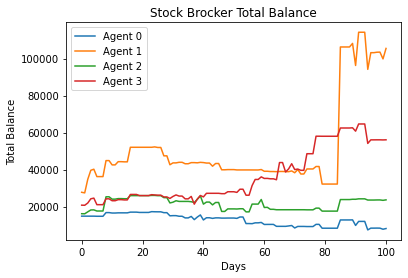

In [19]:
plt.plot(np.arange(0,101),agent_0_green_scores, label="Agent 0")
plt.plot(np.arange(0,101),agent_1_green_scores, label="Agent 1")
plt.plot(np.arange(0,101),agent_2_green_scores, label="Agent 2")
plt.plot(np.arange(0,101),agent_3_green_scores, label="Agent 3")
plt.title('Stock Brocker Total Balance')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Total Balance')
#plt.savefig("miners_green_scores.png")
plt.show()

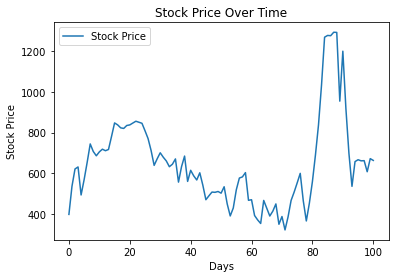

In [20]:
plt.plot(np.arange(0,101),stock_prices, label="Stock Price")
plt.title('Stock Price Over Time')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Stock Price')
#plt.savefig("miners_green_scores.png")
plt.show()

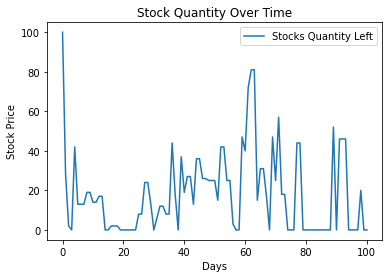

In [21]:
stocks_left = [log["0"]["endogenous"]["StocksLeft"] for log in dense_logs[0]['states']]

plt.plot(np.arange(0,101),stocks_left, label="Stocks Quantity Left")
plt.title('Stock Quantity Over Time')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Stock Price')
#plt.savefig("miners_green_scores.png")
plt.show()

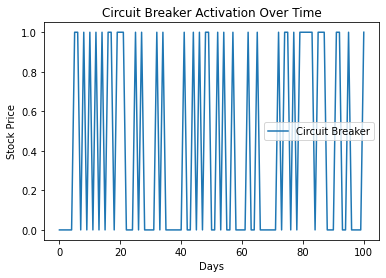

In [22]:
stocks_left = [log["0"]["endogenous"]["AbleToBuy"] for log in dense_logs[0]['states']]

plt.plot(np.arange(0,101),stocks_left, label="Circuit Breaker")
plt.title('Circuit Breaker Activation Over Time')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Stock Price')
#plt.savefig("miners_green_scores.png")
plt.show()

In [23]:
# Shutdown Ray after use
ray.shutdown()